In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv("PPT_Artesia_NM.csv")

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)


In [3]:
# inches → mm
df["ppt_mm"] = df["ppt (inches)"] * 25.4

# Fahrenheit → Celsius
df["tmean_C"] = (df["tmean (degrees F)"] - 32) * 5/9


In [4]:
def thornthwaite(tmean, lat, dates):
    tmean = tmean.clip(lower=0)

    I = (tmean / 5) ** 1.514
    I = I.groupby(dates.dt.year).transform("sum")

    a = (
        6.75e-7 * I**3
        - 7.71e-5 * I**2
        + 1.792e-2 * I
        + 0.49239
    )

    PET = 16 * (10 * tmean / I) ** a

    lat_rad = np.deg2rad(lat)
    month = dates.dt.month

    day_factor = np.array(
        [0.69, 0.72, 0.77, 0.83, 0.89, 0.93,
         0.95, 0.93, 0.89, 0.83, 0.77, 0.72]
    )

    PET = PET * day_factor[month - 1]
    return PET


In [5]:
latitude = 32.84
df["PET"] = thornthwaite(df["tmean_C"], latitude, df["Date"])


In [6]:
df["D"] = df["ppt_mm"] - df["PET"]


In [7]:
df["D_3"] = df["D"].rolling(3).sum()

df["SPEI_3"] = (
    (df["D_3"] - df["D_3"].mean()) /
    df["D_3"].std()
)


In [8]:
#Extracting sumer months only
df["month"] = df["Date"].dt.month
summer = df[df["month"].isin([6, 7, 8])].copy()


In [9]:
summer["year"] = summer["Date"].dt.year

near = summer[(summer["year"] >= 2020) & (summer["year"] < 2070)]
middle = summer[(summer["year"] >= 2070) & (summer["year"] < 2090)]
far = summer[(summer["year"] >= 2090) & (summer["year"] <= 2120)]


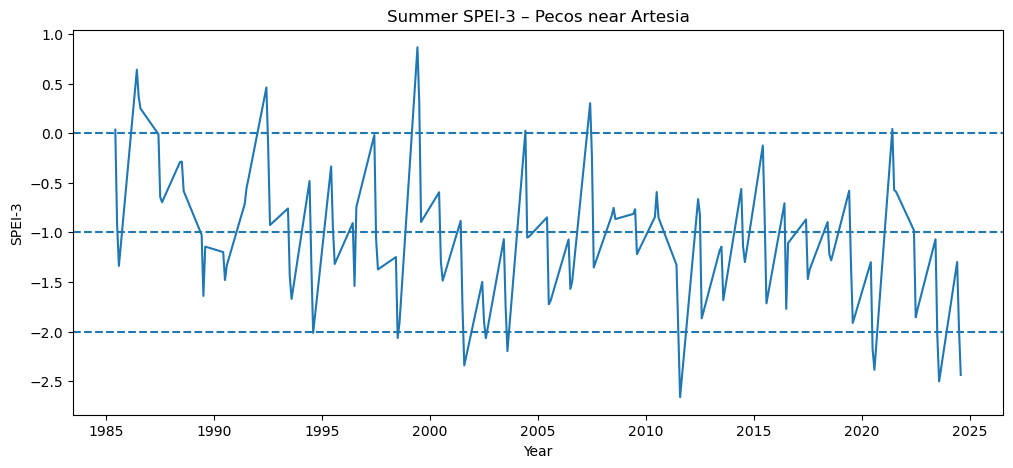

In [10]:
plt.figure(figsize=(12,5))
plt.plot(summer["Date"], summer["SPEI_3"])
plt.axhline(-1, linestyle="--")
plt.axhline(-2, linestyle="--")
plt.axhline(0, linestyle="--")
plt.title("Summer SPEI-3 – Pecos near Artesia")
plt.xlabel("Year")
plt.ylabel("SPEI-3")
plt.show()
